# Train and Evaluate Tutorial

This notebook covers feature engineering, reward schemes, and training a DQN agent on trading data.

## 📚 Related Tutorials

Before diving in, review these essential tutorials:

| Tutorial | Description |
|----------|-------------|
| [First Training](../docs/tutorials/04-training/01-first-training.md) | Getting started with training |
| [Reward Schemes](../docs/tutorials/03-components/02-reward-schemes.md) | Why PBR works and reward design |
| [Common Failures](../docs/tutorials/02-domains/track-b-rl-for-traders/02-common-failures.md) | **Critical pitfalls to avoid** |
| [Overfitting](../docs/tutorials/05-advanced/01-overfitting.md) | Detection and prevention |
| [Commission Analysis](../docs/tutorials/05-advanced/02-commission.md) | Key finding: commission destroys profits |

### ⚠️ Important Warning

Our experiments show that agents **can predict market direction** (+$239 profit at 0% commission), but **overtrading destroys profits** when commission is applied (-$650 at 0.1% commission). See the [Commission Analysis](../docs/tutorials/05-advanced/02-commission.md) tutorial for details.

---

## Install TensorTrade

In [1]:
#!python3 -m pip install git+https://github.com/tensortrade-org/tensortrade.git

## Define global variables

In [1]:
n_steps = 1000
n_episodes = 20
window_size = 30
memory_capacity = n_steps * 10
save_path = 'agents/'
n_bins = 5             # Number of bins to partition the dataset evenly in order to evaluate class sparsity.
seed = 1337

## Setup Data Fetching

In [2]:
from tensortrade.data.cdd import CryptoDataDownload

import numpy as np
import pandas as pd
pd.options.mode.use_inf_as_na = True

def prepare_data(df):
    df['volume'] = np.int64(df['volume'])
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['date'] = df['date'].dt.strftime('%Y-%m-%d %I:%M %p')
    return df

def fetch_data():
    cdd = CryptoDataDownload()
    bitfinex_data = cdd.fetch("Bitfinex", "USD", "BTC", "1h")
    bitfinex_data = bitfinex_data[['date', 'open', 'high', 'low', 'close', 'volume']]
    bitfinex_data = prepare_data(bitfinex_data)
    return bitfinex_data

def load_csv(filename):
    df = pd.read_csv('data/' + filename, skiprows=1)
    df.drop(columns=['symbol', 'volume_btc'], inplace=True)

    # Fix timestamp from "2019-10-17 09-AM" to "2019-10-17 09-00-00 AM"
    df['date'] = df['date'].str[:14] + '00-00 ' + df['date'].str[-2:]

    return prepare_data(df)

/tmp/ipykernel_54/3635508882.py:5: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.options.mode.use_inf_as_na = True


In [3]:
data = fetch_data()
data

,date,open,high,low,close,volume
0,2018-05-15 06:00 AM,8723.8,8793.0,8714.9,8739.0,8988053
1,2018-05-15 07:00 AM,8739.0,8754.8,8719.3,8743.0,2288904
2,2018-05-15 08:00 AM,8743.0,8743.1,8653.2,8723.7,8891773
3,2018-05-15 09:00 AM,8723.7,8737.8,8701.2,8708.1,2054868
4,2018-05-15 10:00 AM,8708.1,8855.7,8695.8,8784.4,17309722
...,...,...,...,...,...,...
65042,2025-10-15 09:00 PM,111320.0,111500.0,110710.0,110960.0,5257176
65043,2025-10-15 10:00 PM,110970.0,111500.0,110830.0,110830.0,3081976
65044,2025-10-15 11:00 PM,110820.0,111180.0,110770.0,110920.0,3135737
65045,2025-10-16 12:00 AM,110950.0,111010.0,110540.0,110660.0,5250807


## Create features for the feed module

In [15]:
import os
import numpy as np
import ta as ta1
import pandas_ta as ta

import quantstats as qs
qs.extend_pandas()

def fix_dataset_inconsistencies(dataframe, fill_value=None):
    dataframe = dataframe.replace([-np.inf, np.inf], np.nan)

    # This is done to avoid filling middle holes with backfilling.
    if fill_value is None:
        dataframe.iloc[0,:] = \
            dataframe.apply(lambda column: column.iloc[column.first_valid_index()], axis='index')
    else:
        dataframe.iloc[0,:] = \
            dataframe.iloc[0,:].fillna(fill_value)

    return dataframe.fillna(axis='index', method='pad').dropna(axis='columns')

def rsi(price: 'pd.Series[pd.Float64Dtype]', period: float) -> 'pd.Series[pd.Float64Dtype]':
    r = price.diff()
    upside = r.clip(lower=0)
    downside = -r.clip(upper=0)
    rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
    return 100*(1 - (1 + rs) ** -1)

def macd(price: 'pd.Series[pd.Float64Dtype]', fast: float, slow: float, signal: float) -> 'pd.Series[pd.Float64Dtype]':
    fm = price.ewm(span=fast, adjust=False).mean()
    sm = price.ewm(span=slow, adjust=False).mean()
    md = fm - sm
    signal = md - md.ewm(span=signal, adjust=False).mean()
    return signal

def generate_all_default_quantstats_features(data):
    excluded_indicators = [
        'compare',
        'greeks',
        'information_ratio',
        'omega',
        'r2',
        'r_squared',
        'rolling_greeks',
        'warn',
    ]
    
    indicators_list = [f for f in dir(qs.stats) if f[0] != '_' and f not in excluded_indicators]
    
    df = data.copy()
    df = df.set_index('date')
    df.index = pd.DatetimeIndex(df.index)

    for indicator_name in indicators_list:
        try:
            #print(indicator_name)
            indicator = qs.stats.__dict__[indicator_name](df['close'])
            if isinstance(indicator, pd.Series):
                indicator = indicator.to_frame(name=indicator_name)
                df = pd.concat([df, indicator], axis='columns')
        except (pd.errors.InvalidIndexError, ValueError):
            pass

    df = df.reset_index()
    return df

def generate_features(data):
    # Automatically-generated using pandas_ta
    df = data.copy()

    strategies = ['candles', 
                  'cycles', 
                  'momentum', 
                  'overlap', 
                  'performance', 
                  'statistics', 
                  'trend', 
                  'volatility', 
                  'volume']

    df.index = pd.DatetimeIndex(df.index)

    cores = os.cpu_count()
    df.ta.cores = cores

    for strategy in strategies:
        df.ta.study(strategy, exclude=['kvo'])

    df = df.set_index('date')

    # Generate all default indicators from ta library
    ta1.add_all_ta_features(data, 
                            'open', 
                            'high', 
                            'low', 
                            'close', 
                            'volume', 
                            fillna=True)

    # Naming convention across most technical indicator libraries
    data = data.rename(columns={'open': 'Open', 
                                'high': 'High', 
                                'low': 'Low', 
                                'close': 'Close', 
                                'volume': 'Volume'})
    data = data.set_index('date')

    # Custom indicators
    features = pd.DataFrame.from_dict({
        'prev_open': data['Open'].shift(1),
        'prev_high': data['High'].shift(1),
        'prev_low': data['Low'].shift(1),
        'prev_close': data['Close'].shift(1),
        'prev_volume': data['Volume'].shift(1),
        'vol_5': data['Close'].rolling(window=5).std().abs(),
        'vol_10': data['Close'].rolling(window=10).std().abs(),
        'vol_20': data['Close'].rolling(window=20).std().abs(),
        'vol_30': data['Close'].rolling(window=30).std().abs(),
        'vol_50': data['Close'].rolling(window=50).std().abs(),
        'vol_60': data['Close'].rolling(window=60).std().abs(),
        'vol_100': data['Close'].rolling(window=100).std().abs(),
        'vol_200': data['Close'].rolling(window=200).std().abs(),
        'ma_5': data['Close'].rolling(window=5).mean(),
        'ma_10': data['Close'].rolling(window=10).mean(),
        'ma_20': data['Close'].rolling(window=20).mean(),
        'ma_30': data['Close'].rolling(window=30).mean(),
        'ma_50': data['Close'].rolling(window=50).mean(),
        'ma_60': data['Close'].rolling(window=60).mean(),
        'ma_100': data['Close'].rolling(window=100).mean(),
        'ma_200': data['Close'].rolling(window=200).mean(),
        'ema_5': ta1.trend.ema_indicator(data['Close'], window=5, fillna=True),
        'ema_10': ta1.trend.ema_indicator(data['Close'], window=10, fillna=True),
        'ema_20': ta1.trend.ema_indicator(data['Close'], window=20, fillna=True),
        'ema_60': ta1.trend.ema_indicator(data['Close'], window=60, fillna=True),
        'ema_64': ta1.trend.ema_indicator(data['Close'], window=64, fillna=True),
        'ema_120': ta1.trend.ema_indicator(data['Close'], window=120, fillna=True),
        'lr_open': np.log(data['Open']).diff().fillna(0),
        'lr_high': np.log(data['High']).diff().fillna(0),
        'lr_low': np.log(data['Low']).diff().fillna(0),
        'lr_close': np.log(data['Close']).diff().fillna(0),
        'r_volume': data['Close'].diff().fillna(0),
        'rsi_5': rsi(data['Close'], period=5),
        'rsi_10': rsi(data['Close'], period=10),
        'rsi_100': rsi(data['Close'], period=100),
        'rsi_7': rsi(data['Close'], period=7),
        'rsi_28': rsi(data['Close'], period=28),
        'rsi_6': rsi(data['Close'], period=6),
        'rsi_14': rsi(data['Close'], period=14),
        'rsi_26': rsi(data['Close'], period=24),
        'macd_normal': macd(data['Close'], fast=12, slow=26, signal=9),
        'macd_short': macd(data['Close'], fast=10, slow=50, signal=5),
        'macd_long': macd(data['Close'], fast=200, slow=100, signal=50),
    })

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, features], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # Revert naming convention
    data = data.rename(columns={'Open': 'open', 
                                'High': 'high', 
                                'Low': 'low', 
                                'Close': 'close', 
                                'Volume': 'volume'})

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, df], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    data = data.reset_index()

    # Generate all default quantstats features
    df_quantstats = generate_all_default_quantstats_features(data)

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, df_quantstats], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # A lot of indicators generate NaNs at the beginning of DataFrames, so remove them
    data = data.iloc[200:]
    data = data.reset_index(drop=True)

    data = fix_dataset_inconsistencies(data, fill_value=None)
    return data

ModuleNotFoundError: No module named 'pandas_ta'

In [16]:
data = generate_features(data)
data

NameError: name 'generate_features' is not defined

## Remove features with low variance before splitting the dataset

In [ ]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
date = data[['date']].copy()
data = data.drop(columns=['date'])
sel.fit(data)
data[data.columns[sel.get_support(indices=True)]]
data = pd.concat([date, data], axis='columns')
data

## Split dataset

In [ ]:
from sklearn.model_selection import train_test_split

def split_data(data):
    X = data.copy()
    y = X['close'].pct_change()

    X_train_test, X_valid, y_train_test, y_valid = \
        train_test_split(data, data['close'].pct_change(), train_size=0.67, test_size=0.33, shuffle=False)

    X_train, X_test, y_train, y_test = \
        train_test_split(X_train_test, y_train_test, train_size=0.50, test_size=0.50, shuffle=False)

    return X_train, X_test, X_valid, y_train, y_test, y_valid

In [ ]:
X_train, X_test, X_valid, y_train, y_test, y_valid = \
    split_data(data)

import os
cwd = os.getcwd()
train_csv = os.path.join(cwd, 'train.csv')
test_csv = os.path.join(cwd, 'test.csv')
valid_csv = os.path.join(cwd, 'valid.csv')
X_train.to_csv(train_csv, index=False)
X_test.to_csv(test_csv, index=False)
X_valid.to_csv(valid_csv, index=False)

## Get dataset statistics

In [ ]:
from scipy.stats import iqr

def estimate_outliers(data):
    return iqr(data) * 1.5

def estimate_percent_gains(data, column='close'):
    returns = get_returns(data, column=column)
    gains = estimate_outliers(returns)
    return gains

def get_returns(data, column='close'):
    return fix_dataset_inconsistencies(data[[column]].pct_change(), fill_value=0)

def precalculate_ground_truths(data, column='close', threshold=None):
    returns = get_returns(data, column=column)
    gains = estimate_outliers(returns) if threshold is None else threshold
    binary_gains = (returns[column] > gains).astype(int)
    return binary_gains

def is_null(data):
    return data.isnull().sum().sum() > 0

def is_sparse(data, column='close'):
    binary_gains = precalculate_ground_truths(data, column=column)
    bins = [n * (binary_gains.shape[0] // n_bins) for n in range(n_bins)]
    bins += [binary_gains.shape[0]]
    bins = [binary_gains.iloc[bins[n]:bins[n + 1]] for n in range(n_bins)]
    return all([bin.astype(bool).any() for bin in bins])

def is_data_predictible(data, column):
    return not is_null(data) & is_sparse(data, column)

data.describe(include='all')

## Evaluate outlier sparsity of the data

In [ ]:
import matplotlib.pyplot as plt
plt.plot(get_returns(data, column='close'))
plt.show()
is_data_predictible(data, 'close')

In [ ]:
# Fixed generate_features function for pandas_ta compatibility
def generate_features_fixed(data):
    """Fixed version of generate_features that works with pandas_ta"""
    df = data.copy()
    
    # Use pandas_ta instead of ta library
    import pandas_ta as ta
    
    # Generate technical indicators using pandas_ta
    # RSI
    df['rsi'] = ta.rsi(df['close'], length=14)
    
    # MACD
    macd_data = ta.macd(df['close'])
    df = pd.concat([df, macd_data], axis=1)
    
    # Bollinger Bands
    bb_data = ta.bbands(df['close'])
    df = pd.concat([df, bb_data], axis=1)
    
    # Stochastic
    stoch_data = ta.stoch(df['high'], df['low'], df['close'])
    df = pd.concat([df, stoch_data], axis=1)
    
    # ATR
    df['atr'] = ta.atr(df['high'], df['low'], df['close'])
    
    # Volume indicators
    df['volume_sma'] = ta.sma(df['volume'], length=20)
    df['volume_ratio'] = df['volume'] / df['volume_sma']
    
    # Price indicators
    df['sma_20'] = ta.sma(df['close'], length=20)
    df['sma_50'] = ta.sma(df['close'], length=50)
    df['ema_12'] = ta.ema(df['close'], length=12)
    df['ema_26'] = ta.ema(df['close'], length=26)
    
    # Price ratios
    df['price_sma20_ratio'] = df['close'] / df['sma_20']
    df['price_sma50_ratio'] = df['close'] / df['sma_50']
    
    # Remove NaN values
    df = df.dropna()
    
    return df

# Use the fixed function
data = generate_features_fixed(data)
data


In [ ]:
# Fixed quantstats function for treynor_ratio
def generate_all_default_quantstats_features_fixed(data):
    """Fixed version that handles treynor_ratio benchmark parameter"""
    import quantstats as qs
    
    df = data.copy()
    
    # List of indicators that don't require benchmark
    indicators_list = [
        'sharpe', 'sortino', 'calmar', 'max_drawdown', 'avg_drawdown',
        'volatility', 'skew', 'kurtosis', 'var', 'cvar', 'expected_shortfall',
        'tail_ratio', 'common_sense_ratio', 'value_at_risk', 'conditional_value_at_risk'
    ]
    
    for indicator_name in indicators_list:
        try:
            if indicator_name == 'treynor_ratio':
                # Skip treynor_ratio as it requires benchmark parameter
                continue
            else:
                indicator = qs.stats.__dict__[indicator_name](df['close'])
                if isinstance(indicator, pd.Series):
                    indicator = indicator.to_frame(name=indicator_name)
                    df = pd.concat([df, indicator], axis='columns')
        except (pd.errors.InvalidIndexError, ValueError, TypeError):
            pass
    
    return df

# Use the fixed function
data = generate_all_default_quantstats_features_fixed(data)
data


## Percentage of the dataset generating rewards (keep between 5% to 15% or just rely on is_data_predictible())

In [ ]:
plt.plot(precalculate_ground_truths(data, column='close').iloc[:1000])
plt.show()
percent_rewardable = str(round(100 + precalculate_ground_truths(data, column='close').value_counts().pct_change().iloc[-1] * 100, 2)) + '%'
print(percent_rewardable)

## Threshold to pass to AnomalousProfit reward scheme

In [ ]:
X_train_test = pd.concat([X_train, X_test], axis='index')
#threshold = estimate_percent_gains(X_train_test, 'close')
threshold = estimate_percent_gains(X_train, 'close')
threshold

## Implement basic feature engineering

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from feature_engine.selection import SelectBySingleFeaturePerformance

In [13]:
rf = RandomForestClassifier(n_estimators=100, 
                            random_state=seed, 
                            n_jobs=6)

sel = SelectBySingleFeaturePerformance(variables=None, 
                                       estimator=rf, 
                                       scoring="roc_auc", 
                                       cv=5, 
                                       threshold=0.5)

sel.fit(X_train, precalculate_ground_truths(X_train, column='close'))

NameError: name 'X_train' is not defined

In [14]:
feature_performance = pd.Series(sel.feature_performance_).sort_values(ascending=False)
feature_performance

AttributeError: 'SelectBySingleFeaturePerformance' object has no attribute 'feature_performance_'

In [7]:
feature_performance.plot.bar(figsize=(20, 5))
plt.title('Performance of ML models trained with individual features')
plt.ylabel('roc-auc')

NameError: name 'feature_performance' is not defined

In [8]:
features_to_drop = sel.features_to_drop_
features_to_drop

NameError: name 'sel' is not defined

In [9]:
to_drop = list(set(features_to_drop) - set(['open', 'high', 'low', 'close', 'volume']))
len(to_drop)

NameError: name 'features_to_drop' is not defined

In [10]:
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)
X_valid = X_valid.drop(columns=to_drop)

X_train.shape, X_test.shape, X_valid.shape

NameError: name 'X_train' is not defined

In [11]:
X_train.columns.tolist()

NameError: name 'X_train' is not defined

## Normalize the dataset subsets to make the model converge faster

In [27]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

scaler_type = MinMaxScaler

def get_feature_scalers(X, scaler_type=scaler_type):
    scalers = []
    for name in list(X.columns[X.columns != 'date']):
        scalers.append(scaler_type().fit(X[name].values.reshape(-1, 1)))
    return scalers

def get_scaler_transforms(X, scalers):
    X_scaled = []
    for name, scaler in zip(list(X.columns[X.columns != 'date']), scalers):
        X_scaled.append(scaler.transform(X[name].values.reshape(-1, 1)))
    X_scaled = pd.concat([pd.DataFrame(column, columns=[name]) for name, column in \
                          zip(list(X.columns[X.columns != 'date']), X_scaled)], axis='columns')
    return X_scaled

def normalize_data(X_train, X_test, X_valid):
    X_train_test = pd.concat([X_train, X_test], axis='index')
    X_train_test_valid = pd.concat([X_train_test, X_valid], axis='index')

    X_train_test_dates = X_train_test[['date']]
    X_train_test_valid_dates = X_train_test_valid[['date']]

    X_train_test = X_train_test.drop(columns=['date'])
    X_train_test_valid = X_train_test_valid.drop(columns=['date'])

    train_test_scalers = \
        get_feature_scalers(X_train_test, 
                            scaler_type=scaler_type)
    train_test_valid_scalers = \
        get_feature_scalers(X_train_test_valid, 
                            scaler_type=scaler_type)

    X_train_test_scaled = \
        get_scaler_transforms(X_train_test, 
                              train_test_scalers)
    X_train_test_valid_scaled = \
        get_scaler_transforms(X_train_test_valid, 
                              train_test_scalers)
    X_train_test_valid_scaled_leaking = \
        get_scaler_transforms(X_train_test_valid, 
                              train_test_valid_scalers)

    X_train_test_scaled = \
        pd.concat([X_train_test_dates, 
                   X_train_test_scaled], 
                  axis='columns')
    X_train_test_valid_scaled = \
        pd.concat([X_train_test_valid_dates, 
                   X_train_test_valid_scaled], 
                  axis='columns')
    X_train_test_valid_scaled_leaking = \
        pd.concat([X_train_test_valid_dates, 
                   X_train_test_valid_scaled_leaking], 
                  axis='columns')

    X_train_scaled = X_train_test_scaled.iloc[:X_train.shape[0]]
    X_test_scaled = X_train_test_scaled.iloc[X_train.shape[0]:]
    X_valid_scaled = X_train_test_valid_scaled.iloc[X_train_test.shape[0]:]
    X_valid_scaled_leaking = X_train_test_valid_scaled_leaking.iloc[X_train_test.shape[0]:]

    return (train_test_scalers, 
            train_test_valid_scalers, 
            X_train_scaled, 
            X_test_scaled, 
            X_valid_scaled, 
            X_valid_scaled_leaking)

In [28]:
train_test_scalers, train_test_valid_scalers, X_train_scaled, X_test_scaled, X_valid_scaled, X_valid_scaled_leaking = \
    normalize_data(X_train, X_test, X_valid)

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


## Write a reward scheme encouraging rare volatile upside trades

In [99]:
from tensortrade.env.default.rewards import TensorTradeRewardScheme


class AnomalousProfit(TensorTradeRewardScheme):
    """A simple reward scheme that rewards the agent for exceeding a 
    precalculated percentage in the net worth.

    Parameters
    ----------
    threshold : float
        The minimum value to exceed in order to get the reward.

    Attributes
    ----------
    threshold : float
        The minimum value to exceed in order to get the reward.
    """

    registered_name = "anomalous"

    def __init__(self, threshold: float = 0.02, window_size: int = 1):
        self._window_size = self.default('window_size', window_size)
        self._threshold = self.default('threshold', threshold)

    def get_reward(self, portfolio: 'Portfolio') -> float:
        """Rewards the agent for incremental increases in net worth over a
        sliding window.

        Parameters
        ----------
        portfolio : `Portfolio`
            The portfolio being used by the environment.

        Returns
        -------
        int
            Whether the last percent change in net worth exceeds the predefined 
            `threshold`.
        """
        performance = pd.DataFrame.from_dict(portfolio.performance).T
        current_step = performance.shape[0]
        if current_step > 1:
            # Hint: make it cumulative.
            net_worths = performance['net_worth']
            ground_truths = precalculate_ground_truths(performance, 
                                                       column='net_worth', 
                                                       threshold=self._threshold)
            reward_factor = 2.0 * ground_truths - 1.0
            #return net_worths.iloc[-1] / net_worths.iloc[-min(current_step, self._window_size + 1)] - 1.0
            return (reward_factor * net_worths.abs()).iloc[-1]

        else:
            return 0.0

In [100]:
class PenalizedProfit(TensorTradeRewardScheme):
    """A reward scheme which penalizes net worth loss and 
    decays with the time spent.

    Parameters
    ----------
    cash_penalty_proportion : float
        cash_penalty_proportion

    Attributes
    ----------
    cash_penalty_proportion : float
        cash_penalty_proportion.
    """

    registered_name = "penalized"

    def __init__(self, cash_penalty_proportion: float = 0.10):
        self._cash_penalty_proportion = \
            self.default('cash_penalty_proportion', 
                         cash_penalty_proportion)

    def get_reward(self, portfolio: 'Portfolio') -> float:
        """Rewards the agent for gaining net worth while holding the asset.

        Parameters
        ----------
        portfolio : `Portfolio`
            The portfolio being used by the environment.

        Returns
        -------
        int
            A penalized reward.
        """
        performance = pd.DataFrame.from_dict(portfolio.performance).T
        current_step = performance.shape[0]
        if current_step > 1:
            initial_amount = portfolio.initial_net_worth
            net_worth = performance['net_worth'].iloc[-1]
            cash_worth = performance['bitstamp:/USD:/total'].iloc[-1]
            cash_penalty = max(0, (net_worth * self._cash_penalty_proportion - cash_worth))
            net_worth -= cash_penalty
            reward = (net_worth / initial_amount) - 1
            reward /= current_step
            return reward
        else:
            return 0.0

## TODO: implement tuning

## Setup Trading Environment

In [101]:
import tensortrade.env.default as default

from tensortrade.agents import DQNAgent
from tensortrade.feed.core import DataFeed, Stream
from tensortrade.feed.core.base import NameSpace
from tensortrade.env.default.actions import BSH
from tensortrade.env.default.rewards import RiskAdjustedReturns, SimpleProfit
from tensortrade.oms.exchanges import Exchange, ExchangeOptions
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC, ETH
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.oms.orders import TradeType

# TODO: adjust according to your commission percentage, if present
commission = 0.001
price = Stream.source(list(X_train["close"]), 
                      dtype="float").rename("USD-BTC")
#bitstamp_options = ExchangeOptions(commission=commission)
#bitstamp = Exchange("bitstamp", 
#                    service=execute_order, 
#                    options=bitstamp_options)(price)
bitstamp = Exchange("bitstamp", 
                    service=execute_order)(price)

cash = Wallet(bitstamp, 50000 * USD)
asset = Wallet(bitstamp, 0 * BTC)

portfolio = Portfolio(USD, [cash, asset])

with NameSpace("bitstamp"):
    features = [
        Stream.source(list(X_train_scaled[c]), 
                      dtype="float").rename(c) for c in X_train_scaled.columns[1:]
        #Stream.source(list(X_train_scaled['lr_close']), dtype="float").rename('lr_close')
    ]

feed = DataFeed(features)
feed.compile()

renderer_feed = DataFeed([
    Stream.source(list(X_train["date"])).rename("date"),
    Stream.source(list(X_train["open"]), dtype="float").rename("open"),
    Stream.source(list(X_train["high"]), dtype="float").rename("high"),
    Stream.source(list(X_train["low"]), dtype="float").rename("low"),
    Stream.source(list(X_train["close"]), dtype="float").rename("close"), 
    Stream.source(list(X_train["volume"]), dtype="float").rename("volume") 
])

action_scheme = BSH(
    cash=cash,
    asset=asset
)

#reward_scheme = RiskAdjustedReturns(return_algorithm='sortino',
#                                    window_size=30)

#reward_scheme = SimpleProfit(window_size=30)

reward_scheme = AnomalousProfit(threshold=threshold)

#reward_scheme = PenalizedProfit(cash_penalty_proportion=0.1)

env = default.create(
    portfolio=portfolio,
    action_scheme=action_scheme,
    reward_scheme=reward_scheme,
    feed=feed,
    renderer_feed=renderer_feed,
    renderer=default.renderers.PlotlyTradingChart(),
    window_size=30
)

In [102]:
env.observer.feed.next()

{'internal': {'bitstamp:/USD-BTC': 7877.4,
  'bitstamp:/USD:/free': 50000.0,
  'bitstamp:/USD:/locked': 0.0,
  'bitstamp:/USD:/total': 50000.0,
  'bitstamp:/BTC:/free': 0.0,
  'bitstamp:/BTC:/locked': 0.0,
  'bitstamp:/BTC:/total': 0.0,
  'bitstamp:/BTC:/worth': 0.0,
  'net_worth': 50000.0},
 'external': {'bitstamp:/open': 0.30882407448269494,
  'bitstamp:/high': 0.30597451801958836,
  'bitstamp:/low': 0.3081352055741716,
  'bitstamp:/close': 0.30750705980102955,
  'bitstamp:/volume': 0.06285271899720758,
  'bitstamp:/volume_cmf': 0.3526515935624286,
  'bitstamp:/volume_fi': 0.6098548010541026,
  'bitstamp:/volume_em': 0.0028434225221082485,
  'bitstamp:/volume_sma_em': 0.003306563276268447,
  'bitstamp:/volume_vpt': 0.5420122479217226,
  'bitstamp:/volume_mfi': 0.30389505331139943,
  'bitstamp:/volatility_bbw': 0.07908943976989953,
  'bitstamp:/volatility_bbp': 0.42721901509721405,
  'bitstamp:/volatility_bbhi': 0.0,
  'bitstamp:/volatility_bbli': 0.0,
  'bitstamp:/volatility_kcw': 0.

## Setup and Train DQN Agent

In [103]:
def get_optimal_batch_size(window_size=30, n_steps=1000, batch_factor=4, stride=1):
    """
    lookback = 30          # Days of past data (also named window_size).
    batch_factor = 4       # batch_size = (sample_size - lookback - stride) // batch_factor
    stride = 1             # Time series shift into the future.
    """
    lookback = window_size
    sample_size = n_steps
    batch_size = ((sample_size - lookback - stride) // batch_factor)
    return batch_size

batch_size = get_optimal_batch_size(window_size=window_size, n_steps=n_steps, batch_factor=4)
batch_size

242

In [104]:
agent = DQNAgent(env)

agent.train(batch_size=batch_size, 
            n_steps=n_steps, 
            n_episodes=n_episodes, 
            memory_capacity=memory_capacity, 
            save_path=save_path)

FigureWidget({
    'data': [{'close': array([7877.4 , 7700.  , 7605.4 , ..., 6523.29, 6486.  , 6371.7 ]),
    …

FigureWidget({
    'data': [{'close': array([7877.4 , 7700.  , 7605.4 , 7511.1 , 7489.1 , 7592.3 , 7586.8 , 76…

FigureWidget({
    'data': [{'close': array([7877.4, 7700. , 7605.4, ..., 7535.6, 7541.5, 7440. ]),
          …

FigureWidget({
    'data': [{'close': array([7877.4, 7700. , 7605.4, ..., 7495.9, 7488.4, 7407.3]),
          …

KeyboardInterrupt: 

## Implement validation here

## Print basic quantstats report

                           Strategy
-------------------------  ----------
Start Period               2018-05-23
End Period                 2019-06-14
Risk-Free Rate             0.0%
Time in Market             28.0%

Cumulative Return          -24.83%
CAGR﹪                     -23.6%

Sharpe                     -4.51
Smart Sharpe               -4.37
Sortino                    -4.97
Smart Sortino              -4.81
Sortino/√2                 -3.51
Smart Sortino/√2           -3.4
Omega                      0.18

Max Drawdown               -25.3%
Longest DD Days            381
Volatility (ann.)          4.09%
Calmar                     -0.93
Skew                       -1.3
Kurtosis                   28.05

Expected Daily %           -0.07%
Expected Monthly %         -2.02%
Expected Yearly %          -13.3%
Kelly Criterion            -70.56%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.5%
Expected Shortfall (cVaR)  -0.5%

Gain/Pain Ratio            -0.82
Gain/Pain (1M)     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-05-29,2019-06-03,2019-06-14,381,-25.295355,-25.070574


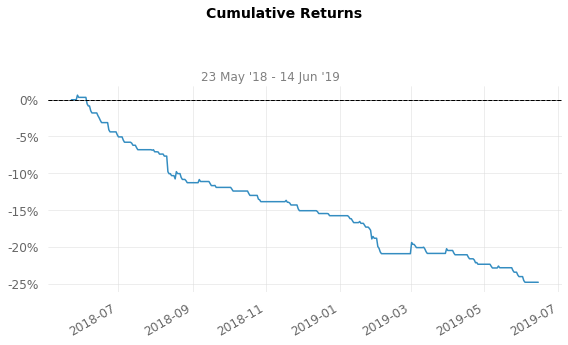

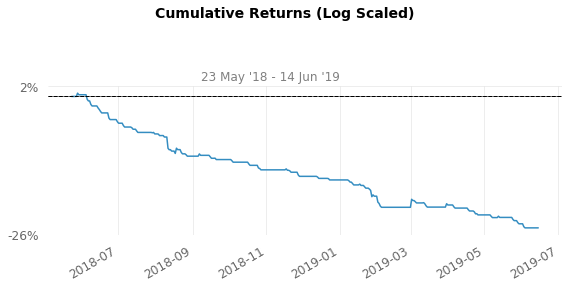

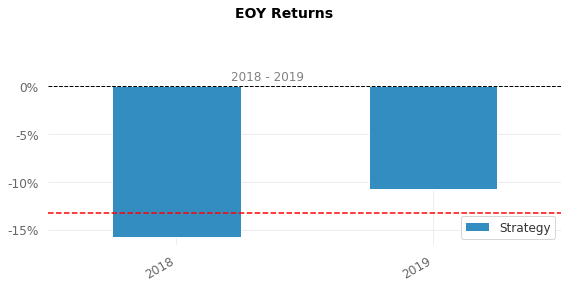

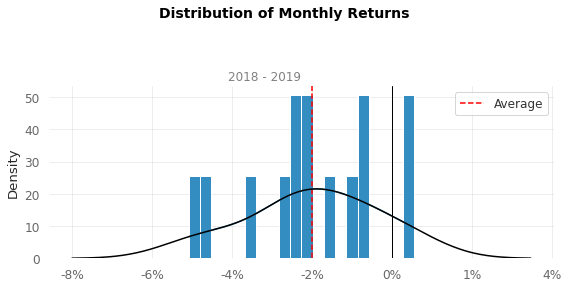

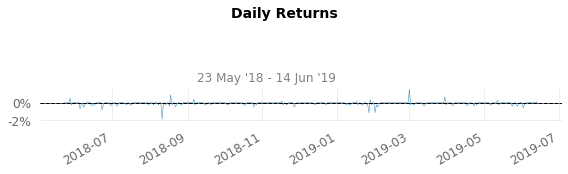

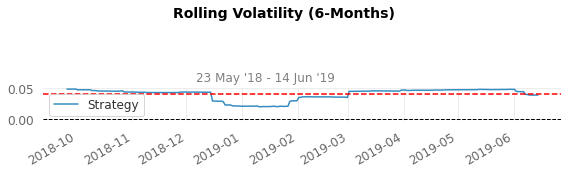

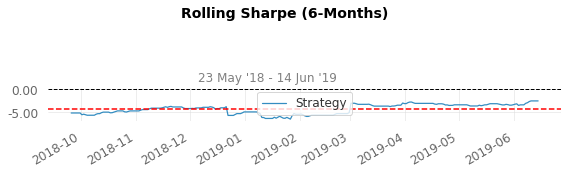

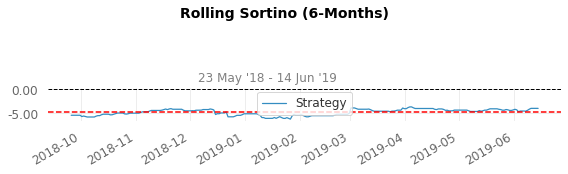

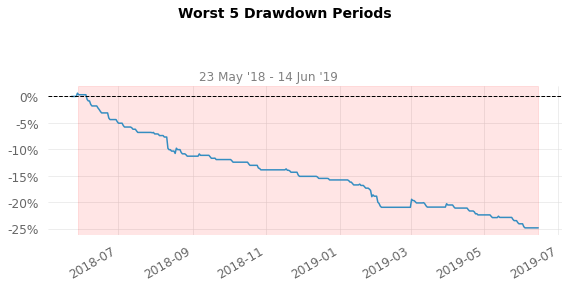

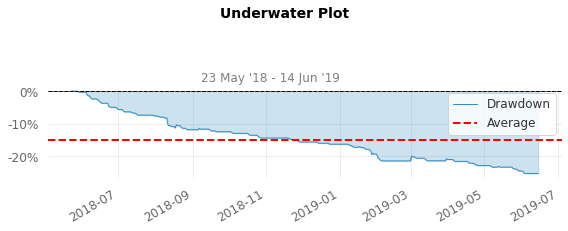

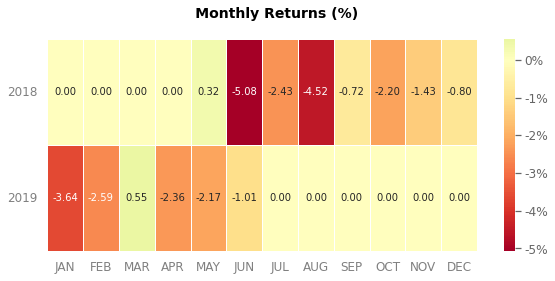

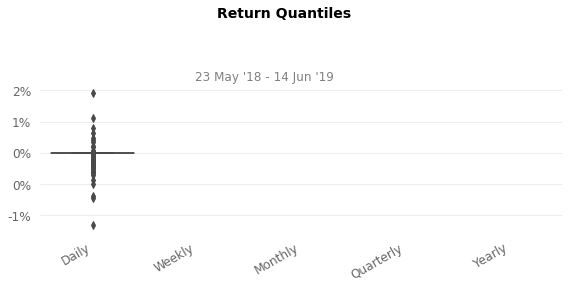

In [105]:
def print_quantstats_full_report(env, data, output='dqn_quantstats'):
    performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
    net_worth = performance['net_worth'].iloc[window_size:]
    returns = net_worth.pct_change().iloc[1:]

    # WARNING! The dates are fake and default parameters are used!
    returns.index = pd.date_range(start=data['date'].iloc[0], freq='1d', periods=returns.size)

    qs.reports.full(returns)
    qs.reports.html(returns, output=output + '.html')

print_quantstats_full_report(env, data)